In [ ]:
# default_exp training

# Training Data

In [ ]:
#export
import matplotlib.pyplot as plt
import numpy as np
import PIL
import chessocr
import re
import chess.pgn
import pickle

from functools import partial
from pathlib import Path
from PIL import Image, ImageDraw
from collections import namedtuple
from fastai.vision.all import *
from itertools import product
from IPython.core.pylabtools import print_figure
from random import randint
from random import shuffle
from random import choice
from numpy.random import normal

from chessocr import *
from fastai.data.all import *
from collections.abc import MutableSequence, Mapping

In [ ]:
URLs.chess_small

'https://chess-screenshots.s3.amazonaws.com/chess-small.tgz'

In [ ]:
boards_url

Path('/Users/id/nbs/07-chessocrnb/chessocr/img/boards')

In [ ]:
pieces_url

Path('/Users/id/nbs/07-chessocrnb/chessocr/img/pieces')

In [ ]:
#export
websites_url = untar_data(URLs.website)
m = re.compile('^[0-9]+$')
piece_dirs = sorted([_ for _ in pieces_url.iterdir() if m.match(_.name)], key=lambda i: int(i.name))

## Boards and Board

In [ ]:
#export
def assert_coord(coord):
    assert len(coord)==2
    assert coord[0] in 'abcdefgh'
    assert coord[1] in '12345678'

In [ ]:
#export
class Board(PIL.Image.Image):
    """ 
        Represents a rendered board with particular dark and light colors.
        There are no pieces on the board.
        
        so far assumes the board is oriented towards the white player
    """
    _filemap=dict(zip('abcdefgh', '01234567'))
    _rankmap=dict(zip('12345678', '76543210'))
    def __init__(self, url): 
        self.url = url
        self.reset()
    def reset(self): self.img = Image.open(self.url).convert('RGBA')
    def __getattr__(self, attr):
        if hasattr(self.img, attr): 
            return getattr(self.img, attr)
        else:
            raise AttributeError
    def bbox(self, coord):
        """ bounding box for chess coordinate like a8, b7, f6, etc """
        assert_coord(coord)
        file=int(self._filemap[coord[0]])
        rank=int(self._rankmap[coord[1]])
        dx=self.img.size[0]//8
        dy=self.img.size[1]//8
        x0=file*dx
        y0=rank*dy
        x1=x0+dx
        y1=y0+dy
        return (x0, y0, x1, y1,)

In [ ]:
[Board(choice(get_image_files(boards_url))).bbox('a1') for _ in range(5)]

[(0, 350, 50, 400),
 (0, 350, 50, 400),
 (0, 350, 50, 400),
 (0, 350, 50, 400),
 (0, 350, 50, 400)]

In [ ]:
#export
class Boards(Sequence):
    """ 
        Container object holding `Board` objects.
    """
    def __init__(self, url):
        self.url = url
        self.boards = ([Board(_) for _ in get_image_files(self.url)])
        self._png_data = None
    def __len__(self):          return len(self.boards)
    def __getitem__(self, key): return self.boards[key]
    def __setitem__(self, key, value): self.boards[key] = value

    def _repr_png_(self): 
        if not self._png_data:
            self._png_data = self._figure_data()
        return self._png_data

    def _figure_data(self):
        rows = len(self) // 9 + 1
        fig, axs = plt.subplots(rows, 7, figsize=(14, 8))
        for i in range(len(self)):
            ax=axs.ravel()[i]
            ax.imshow(self[i].img)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"{i}")

        data = print_figure(fig)
        plt.close(fig)
        return data

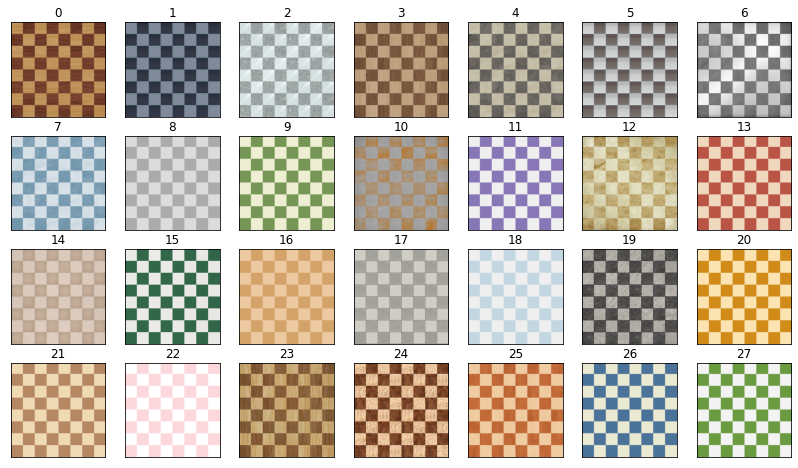

In [ ]:
#export
boards = Boards(boards_url)
boards

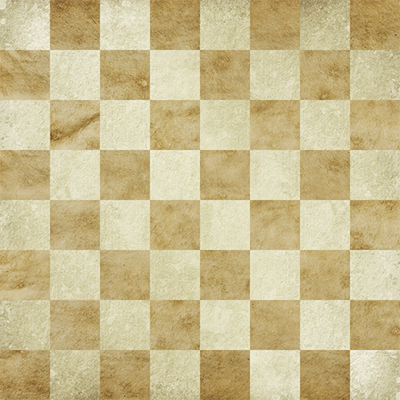

In [ ]:
shuffle(boards)
boards[27]

## PieceSet and PieceSets

In [ ]:
#export
class PieceSet:
    """ 
        Represents the 12 individual pieces comprising a chess set. 
        This includes a rook, knight, bishop, queen, king, and pawn for both black and white pieces.
    """
    _attrs = [f'{_[0]}{_[1]}' for _ in product('wb', 'rnbqkp')]
    
    def __init__(self, dir): 
        self.dir = dir
        self._png_data = None
        
    def _repr_png_(self):
        if not self._png_data:
            self._png_data = self._figure_data('png')
        return self._png_data

    def __getattr__(self, attr):
        if attr not in self._attrs: raise AttributeError
        return Image.open(self.dir/f'{attr[1]}_{attr[0]}.png').convert('RGBA')

    def _figure_data(self, format):
        fig, axs = plt.subplots(2, 6, gridspec_kw={'hspace':-0.5, 'wspace':0}, figsize=(8, 4))
        for i, attr in enumerate(list(self._attrs)):
            ax=axs.ravel()[i]
            ax.imshow(getattr(self, attr))
            ax.set_xticks([])
            ax.set_yticks([])
    
        fig.suptitle(self.dir.as_posix())
        data = print_figure(fig)
        plt.close(fig)
        return data

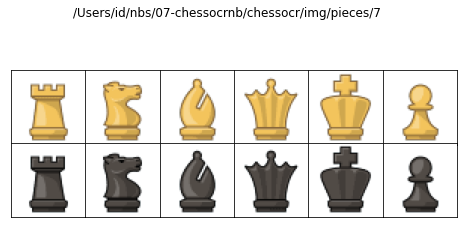

In [ ]:
PieceSet(choice(piece_dirs))

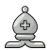

In [ ]:
PieceSet(choice(piece_dirs)).wb

In [ ]:
#export
class PieceSets(Sequence):
    def __init__(self, dirs): self.sets = [PieceSet(_) for _ in dirs]
    def __getitem__(self, key): return self.sets[key]
    def __setitem__(self, key, value): self.sets[key] = value
    def __len__(self): return len(self.sets)

In [ ]:
#export
pieces=PieceSets(piece_dirs)

In [ ]:
shuffle(pieces)

## FEN

In [ ]:
#export
class FEN:
    """ represents a fen string with convenience methods to find the piece on each square """
    
    # used to map from the board coordinate to index in 64 len string
    _filemap=dict(zip('abcdefgh', range(0, 9)))
    _rankmap=dict(zip('12345678', range(0, 64, 8)[::-1]))    

    @staticmethod
    def converter(p):
        if p == "_": return "__"
        elif p.isupper(): return f'w{p.lower()}'
        else: return f'b{p.lower()}'
    
    def __init__(self, fen):
        chars='RNBQKPrnbqkp/12345678'
        assert fen.count("/") == 7
        assert all([_ in chars for _ in fen])
        self.fen=fen
        assert len(format(self))==64
        
    def __repr__(self): return "FEN(\"{}\")".format(self.fen)
    
    def __str__(self): 
        return "\n".join([format(self)[0:8],
                          format(self)[8:16],
                          format(self)[16:24],
                          format(self)[24:32],
                          format(self)[32:40],
                          format(self)[40:48],
                          format(self)[48:56],
                          format(self)[56:], "\n"
                         ])
    
    def __format__(self, format_spec=""):
        if format_spec == "":
            f = self.fen
            for i in '12345678': f=f.replace(i, '_'*int(i))
            return f.replace("/", "")                

    def __iter__(self):
        return iter(
            [(f'{f}{r}', FEN.converter(getattr(self, f'{f}{r}')),) 
                     for f, r, in product('abcdefgh', '12345678')]
        )
#                      if getattr(self, f'{f}{r}') != '_'])
    
    def __getattr__(self, attr):
        try:
            assert_coord(attr)
        except AssertionError:
            raise AttributeError
        file=self._filemap[attr[0]]
        rank=self._rankmap[attr[1]]
        idx = file+rank
        return format(self)[idx]

In [ ]:
s="rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR"
print(FEN(s))

rnbqkbnr
pppppppp
________
________
____P___
________
PPPP_PPP
RNBQKBNR




In [ ]:
[_ for _ in FEN(s)][:5]

[('a1', 'wr'), ('a2', 'wp'), ('a3', '__'), ('a4', '__'), ('a5', '__')]

In [ ]:
repr(FEN(s))

'FEN("rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR")'

In [ ]:
test_eq(FEN(s).e4, 'P')
test_eq(FEN(s).a1, 'R')
test_eq(FEN(s).a8, 'r')
test_eq(FEN(s).h1, 'R')
test_eq(FEN(s).h8, 'r')
test_eq(FEN(s).e3, '_')
test_eq(FEN(s).e1, 'K')
test_eq(FEN(s).e8, 'k')
test_eq(FEN(s).c5, '_')

## FEN Generator

In [ ]:
#export
class FENs(Sequence):
    fenpath = "data/fens.pth"
    pgnpath = "data/small.pgn"
    
    def __init__(self):
        p = Path(chessocr.__file__).parent / self.fenpath

        try:
            with open(p, 'rb') as f:
                fens = pickle.load(f)
        except FileNotFoundError:
            pgn = Path(chessocr.__file__).parent / self.pgnpath
            fens = list(self._make_fens(pgn))
            with open(p, 'wb') as f:
                pickle.dump(fens, f)
                
        self._fens = [FEN(_) for _ in fens]
        del fens
    
    def _make_fens(self, path):
        """ generator through all the fens in a game object the pgns in a file """
        def game(path):
            """ generator through all the pgns in a file """
            with open(path) as pgn:
                while True:
                    try: game = chess.pgn.read_game(pgn)
                    except UnicodeDecodeError: continue
                    if game is None: break
                    yield game

        for g in game(path):        
            board = g.board()
            for move in g.mainline_moves():
                board.push(move)
                yield board.fen().split()[0]
        
    def __getitem__(self, item): return self._fens[item]
    def __len__(self): return len(self._fens)

In [ ]:
#export
fens = FENs()

In [ ]:
#export
pgn_url = Path(chessocr.__file__).parent.parent/"pgn"
pgn = pgn_url/"Kasparov.pgn"
small = pgn_url/"small.pgn"

## GameBoard

In [ ]:
#export
class GameBoard:
    """
        Represents a combination of a Board, PieceSet, and optionally a FEN to create the position.
        If no fen is provided, the GameBoard will be in the starting position
    """
    def __init__(self, board, pieces, fen=FEN("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR")):
        self.board = board
        self.pieces = pieces
        self.fen=fen
        self._render()
    
    def _render(self):
        if not self.fen:
            return
        for s, p in self.fen:
            img=self.board.img
            board=self.board
            pieces=self.pieces
            try: 
                img.paste(getattr(pieces, p), board.bbox(s), getattr(pieces, p))
            except AttributeError:
                pass
        
    def _repr_png_(self): return self.board._repr_png_()

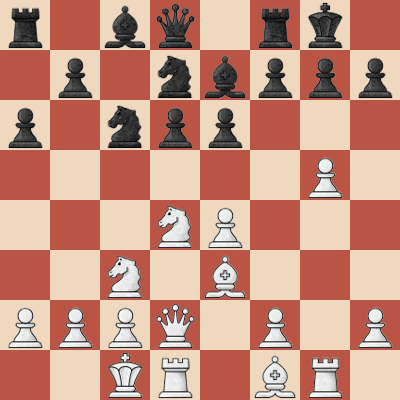

In [ ]:
board = choice(boards)
board.reset()
gb = GameBoard(board, choice(pieces), choice(fens)); gb

## Backgrounds

In [ ]:
#export
sites = get_image_files(websites_url)

In [ ]:
url = Path("/Users/id/.fastai/data/chess")

* mapping of iterators
* key - dir name
* value - iterator next name

In [ ]:
dirs=dict()
dirs[path]=FileNamer(path)

In [ ]:
next(dirs[path])

Path('/Users/id/.fastai/data/chesspiece/0000012.png')

In [ ]:
#export
class FileNamer(Iterator):
    """ holds state for file names to prevent having to search the whole dir 
        to figure out what the next name should be when generating data
    """
    def __init__(self, path, format_spec="{:07d}"): 
        self.path=path
        m = re.compile('^[0-9]+$')
        files = [int(_.stem) for _ in get_files(self.path) if m.match(_.stem)]
        try: self.start = max(files)
        except ValueError: self.start = 0
        self.format_spec = format_spec
    
    def __next__(self):
        self.start+=1
        return self.path / "{}.png".format(self.format_spec.format(self.start))

In [ ]:
board_out

Path('/Users/id/.fastai/data/chess')

## Render

In [ ]:
#export
class Render:
    """ creates a training sample from the constituent parts """
    def __init__(self, board, piece, fen, backurl, dirs=None):
        self.board=board
        self.piece=piece
        self.fen=fen
        self.backurl=backurl
        self.background=Image.open(self.backurl)
        self.gameboard=GameBoard(self.board, self.piece, self.fen)
        self.dirs = dirs
        self._render()
    
    def _render(self):
        size = max(min(int(normal(self.board.size[0], self.board.size[0]/3)), min(self.background.size)), 100)
        dx = int(random.uniform(0, self.background.size[0] - size))
        dy = int(random.uniform(0, self.background.size[1] - size))
        self.background.paste(self.board.resize((size, size)), (dx, dy, dx+size, dy+size))
        self.size,self.dx,self.dy = size, dx, dy
    
    def save(self): 
        path = next(self.dirs['board'])
        self.background.save(path)
        
    @property
    def label(self):
        return (self.size, self.dx, self.dy, self.backurl.name, format(self.fen), self.board.url.name,
               self.piece.dir.name)

    def save_slices(self):
        for coord, piece in self.fen:
            img = self.bbox(coord)
            path = next(self.dirs[piece[-1]])
            img.save(path)
            
    def bbox(self, coord):
        x0,y0,x1,y1=self.board.bbox(coord)
        scale = self.size / 400
        # totally not correct. x0 and y0 must also scale
        std=5*scale
        rando=partial(np.random.normal, 0, std)
        bbox= (x0*scale+self.dx + rando(), 
               y0*scale+self.dy + rando(),
               x1*scale+self.dx + rando(),
               y1*scale+self.dy + rando(),)
        return self.background.crop( bbox )

    def _repr_png_(self):
        ratio=0.5
        return self.background.resize((int(self.background.shape[1]*ratio), 
                                       int(self.background.shape[0]*ratio)))._repr_png_()

In [ ]:
dirs={}
dirs["board"]=FileNamer(board_out)
path = Path.home() / ".fastai/data/chesspiece/"
pieces=['r', 'n', 'b', 'q', 'k', 'p', '_']
for _ in pieces:
    Path.mkdir(path/_, parents=True, exist_ok=True)
    dirs[_] = FileNamer(path/_)

In [ ]:
dirs

{'board': <__main__.FileNamer at 0x7f9b8130f790>,
 'r': <__main__.FileNamer at 0x7f9b91ec0050>,
 'n': <__main__.FileNamer at 0x7f9b91ec0910>,
 'b': <__main__.FileNamer at 0x7f9b91ec01d0>,
 'q': <__main__.FileNamer at 0x7f9b91ec0410>,
 'k': <__main__.FileNamer at 0x7f9b91ec0c50>,
 'p': <__main__.FileNamer at 0x7f9b91ec0290>,
 '_': <__main__.FileNamer at 0x7f9b91ec0fd0>}